### Import Packages

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, dirichlet

### Load in Data

In [12]:
data = pd.read_csv("Data/data.csv")
data.head()

,PITCH_TYPE,PITCH_NAME,PLAYER_NAME,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_PK,GAME_YEAR,GAME_DATE,...,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE,POST_AWAY_SCORE,POST_HOME_SCORE,POST_BAT_SCORE,POST_FLD_SCORE,DELTA_HOME_WIN_EXP,DELTA_RUN_EXP
0,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.038
1,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.049
2,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.052
3,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.113
4,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.077


### Data Cleaning

In [13]:
# Drop rows where PITCH_TYPE is Other, Pitch Out, or NA
# Other - Typically fastballs, but can't be 100% sure without pitch metric data
# Pitch Out - Insignificant amount of data. Not relevant for a hitter's pitch mix
# NAs - Don't know anything about the pitch if it is a NA, so we can't broadly classify it
data = data[(~data['PITCH_TYPE'].isin(['FA', 'PO'])) & (data['PITCH_TYPE'].notna()) & (data['BALLS'] != 4) & (data['STRIKES'] != 3)]

In [14]:
pitch_type_to_class_map = {
    'CH': 'OS',
    'CS': 'BB', 
    'CU': 'BB', 
    'EP': 'OS',
    'FC': 'FB',
    'FF': 'FB',
    'FO': 'OS',
    'FS': 'OS',
    'KC': 'BB',
    'KN': 'OS',
    'SC': 'BB',
    'SI': 'FB',
    'SL': 'BB',
    'ST': 'BB',
    'SV': 'BB'
}

pitch_name_to_class_map = {
    '4-Seam Fastball': 'Fastball', 
    'Slider': 'Breaking Ball', 
    'Sinker': 'Fastball', 
    'Knuckle Curve': 'Breaking Ball',
    'Curveball': 'Breaking Ball', 
    'Changeup': 'Off-speed',
    'Cutter': 'Fastball', 
    'Sweeper': 'Breaking Ball', 
    'Split-Finger': 'Off-speed',
    'Slurve': 'Breaking Ball', 
    'Slow Curve': 'Breaking Ball', 
    'Eephus': 'Off-speed',
    'Knuckleball': 'Off-speed',
    'Forkball': 'Off-speed', 
    'Screwball': 'Breaking Ball'
}

In [15]:
data['PITCH_CLASS'] = data[['PITCH_TYPE']].replace(pitch_type_to_class_map)
data['PITCH_CLASS_NAME'] = data[['PITCH_NAME']].replace(pitch_name_to_class_map)

In [17]:
data_subset = data[['PITCH_CLASS', 'PITCH_CLASS_NAME', 'PITCH_TYPE', 'PITCH_NAME', 'PLAYER_NAME', 'BATTER_ID', 'BAT_SIDE', 'THROW_SIDE', 'GAME_YEAR', 'BALLS', 'STRIKES', 'PLATE_X', 'PLATE_Z', 'SZ_TOP', 'SZ_BOT']]
data_subset.to_csv("Data/full_training_data.csv", index=False)

### Get Batter Pitch Mix for Each Year

In [7]:
total_pitches_per_batter_year = data_subset.groupby(["GAME_YEAR", "BATTER_ID"]).size()
count_pitch_class_per_batter_year = data_subset.groupby(['PITCH_CLASS', 'PITCH_CLASS_NAME', 'BATTER_ID', 'GAME_YEAR']).size().reset_index(name='count')
count_pitch_class_per_batter_year['total_count'] = count_pitch_class_per_batter_year.set_index(['GAME_YEAR', 'BATTER_ID']).index.map(total_pitches_per_batter_year)
count_pitch_class_per_batter_year['PCT_PITCH_CLASS_SEEN'] = count_pitch_class_per_batter_year['count'] / count_pitch_class_per_batter_year['total_count']
count_pitch_class_per_batter_year = count_pitch_class_per_batter_year.drop(columns=['count', 'total_count'])
count_pitch_class_per_batter_year.head()

,PITCH_CLASS,PITCH_CLASS_NAME,BATTER_ID,GAME_YEAR,PCT_PITCH_CLASS_SEEN
0,BB,Breaking Ball,444482,2021,0.269156
1,BB,Breaking Ball,444482,2022,0.279781
2,BB,Breaking Ball,444482,2023,0.267016
3,BB,Breaking Ball,453568,2021,0.233287
4,BB,Breaking Ball,453568,2022,0.241595


In [8]:
pitch_mix_pivoted = count_pitch_class_per_batter_year.pivot(index=['PITCH_CLASS', 'PITCH_CLASS_NAME', 'BATTER_ID'], 
                                          columns='GAME_YEAR', 
                                          values='PCT_PITCH_CLASS_SEEN').reset_index()
pitch_mix_pivoted

GAME_YEAR,PITCH_CLASS,PITCH_CLASS_NAME,BATTER_ID,2021,2022,2023
0,BB,Breaking Ball,444482,0.269156,0.279781,0.267016
1,BB,Breaking Ball,453568,0.233287,0.241595,0.237310
2,BB,Breaking Ball,456781,0.309036,0.338448,0.309457
3,BB,Breaking Ball,457705,0.344887,0.319203,0.322372
4,BB,Breaking Ball,457759,0.317647,0.270901,0.288764
...,...,...,...,...,...,...
937,OS,Off-speed,691718,NaN,NaN,0.054795
938,OS,Off-speed,693304,NaN,NaN,0.124498
939,OS,Off-speed,694384,NaN,NaN,0.152830
940,OS,Off-speed,696285,NaN,NaN,0.079399


### Scatterplots by Pitch Class

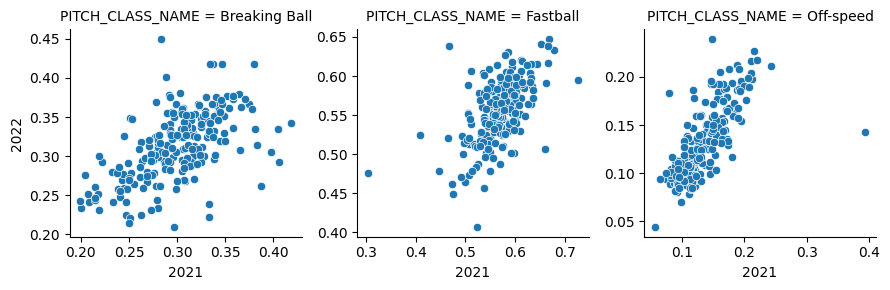

In [9]:
g = sns.FacetGrid(pitch_mix_pivoted.dropna(subset=[2021, 2022]), sharex=False, sharey=False, col="PITCH_CLASS_NAME", col_wrap=3)
g.map(sns.scatterplot, 2021, 2022)

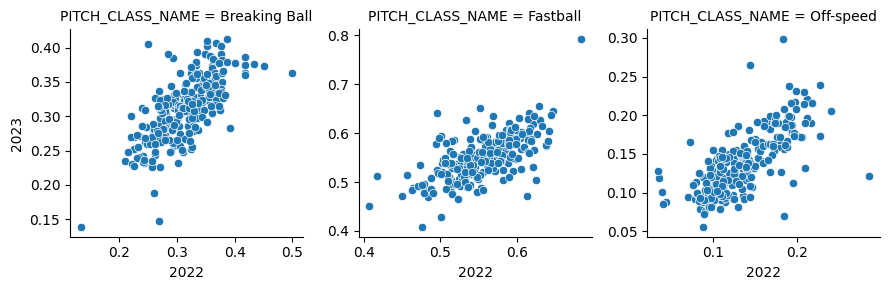

In [10]:
g = sns.FacetGrid(pitch_mix_pivoted.dropna(subset=[2022, 2023]), sharex=False, sharey=False, col="PITCH_CLASS_NAME", col_wrap=3)
g.map(sns.scatterplot, 2022, 2023)

### Correlation Across Years

In [11]:
pitch_mix_pivoted.dropna(subset=[2021, 2022]).groupby("PITCH_CLASS_NAME").apply(lambda grp: pearsonr(grp[2021], grp[2022]), include_groups=False)

PITCH_CLASS_NAME
Breaking Ball    (0.5789418887757181, 9.987694230132565e-21)
Fastball         (0.5568902800026445, 5.425072650917765e-19)
Off-speed        (0.7168742536875149, 4.709885104543771e-35)
dtype: object

In [12]:
pitch_mix_pivoted.dropna(subset=[2022, 2023]).groupby("PITCH_CLASS_NAME").apply(lambda grp: pearsonr(grp[2022], grp[2023]), include_groups=False)

PITCH_CLASS_NAME
Breaking Ball     (0.7023080644454134, 7.53056149411023e-41)
Fastball         (0.6550753846804735, 5.442890954544187e-34)
Off-speed        (0.7298781689529442, 2.376907346002093e-45)
dtype: object

In [13]:
pitch_mix_pivoted.dropna(subset=[2021, 2023]).groupby("PITCH_CLASS_NAME").apply(lambda grp: pearsonr(grp[2021], grp[2023]), include_groups=False)

PITCH_CLASS_NAME
Breaking Ball     (0.5904789093962814, 7.082924805026147e-22)
Fastball          (0.5901078875157025, 7.620982756394241e-22)
Off-speed        (0.6951021686400481, 1.1917906665158283e-32)
dtype: object

### Summary

Looking broadly at each batter in the dataset, we can see that there is a year to year correlation between a batter's pitch mix. Taking 2023 as our target year, we see that the correlation coefficient for 2022 is stronger than 2021, indicating that recent years may more predictive power than years further in the past.

In [18]:
data = pd.read_csv("Data/full_training_data.csv")

In [19]:
data.head()

,PITCH_CLASS,PITCH_CLASS_NAME,PITCH_TYPE,PITCH_NAME,PLAYER_NAME,BATTER_ID,BAT_SIDE,THROW_SIDE,GAME_YEAR,BALLS,STRIKES,PLATE_X,PLATE_Z,SZ_TOP,SZ_BOT
0,FB,Fastball,FF,4-Seam Fastball,"Betts, Mookie",605141,R,R,2021,0,0,0.07,4.16,3.46,1.76
1,FB,Fastball,FF,4-Seam Fastball,"Betts, Mookie",605141,R,R,2021,1,0,0.19,2.60,3.29,1.49
2,FB,Fastball,FF,4-Seam Fastball,"Betts, Mookie",605141,R,R,2021,1,1,-0.61,3.65,3.34,1.64
3,FB,Fastball,FF,4-Seam Fastball,"Betts, Mookie",605141,R,R,2021,2,1,0.52,3.95,3.29,1.58
4,FB,Fastball,FF,4-Seam Fastball,"Betts, Mookie",605141,R,R,2021,3,1,0.07,3.09,3.22,1.55
